# Custom neural network combined with tensor train

Let's hacking `Pompon`!

One will use tensor train implementaion in `Pompon` and customized neural network build by [Flax](https://flax.readthedocs.io/en/latest/)

![](assets/pompon-flax.png)

Before start, install `Flax`.
In this example, we will follow [`flax.nnx`](https://flax-nnx.readthedocs.io/en/latest/) API rather than [`flax.linen`](https://flax-linen.readthedocs.io/en/latest/) API.

In [1]:
try:
    from flax import nnx
except ModuleNotFoundError:
    !uv pip install --quiet flax

## Import modules

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from tqdm.auto import tqdm

from pompon import DTYPE
from pompon._jittables import _forward_basis2y
from pompon.layers.tt import TensorTrain
from pompon.optimizer.sweeper import sweep

## Prepare training data

We will use
$$
y = \boldsymbol{x}A\boldsymbol{x}^\top
$$
as a true function

In [3]:
def generate_data(num_samples, key, include_f=True):
    mean = jnp.zeros(3)
    cov = jnp.eye(3)
    k = 1.0

    A = k * jnp.linalg.inv(cov)

    x_samples = jax.random.multivariate_normal(
        key=key, mean=mean, cov=cov, shape=(num_samples,), dtype=DTYPE
    )
    y_samples = jnp.einsum("ni,ij,nj->n", x_samples, A, x_samples)

    if include_f:
        f_samples = -2.0 * x_samples @ A
        return x_samples, y_samples[:, jnp.newaxis], f_samples
    else:
        return x_samples, y_samples[:, jnp.newaxis]


num_samples = 256
key = jax.random.PRNGKey(0)
x_samples, y_samples, f_samples = generate_data(num_samples, key)

print("x samples:", x_samples.shape, x_samples.dtype)
print("y samples:", y_samples.shape, y_samples.dtype)
print("f samples:", f_samples.shape, f_samples.dtype)

x samples: (256, 3) float64
y samples: (256, 1) float64
f samples: (256, 3) float64


## Define Custom Network

### Define Basis function

Define network like this;

![](assets/nn-basis.png)

where $\phi_{\rho_i}(x_i): \mathbb{R}\to\mathbb{R}^d$ and $d$ is a number of basis (`chunk_size`).

In [4]:
class CustomBasis(nnx.Module):
    """
    Args:
        num_chunks (int): degree of freedoms n
        hidden_size (int): hidden layer size
        chunk_size (int): number of basis for each mode
        n_layers (int): number of hidden layers
        rngs (nnx.Rngs): random generator

    """

    def __init__(
        self,
        num_chunks: int,
        hidden_size: int,
        chunk_size: int,
        n_layers: int,
        x_scale: jax.Array,
        rngs: nnx.Rngs,
    ):
        self.num_chunks = num_chunks
        self.hidden_size = hidden_size
        self.chunk_size = chunk_size
        self.n_layers = n_layers
        self.x_scale = x_scale
        initializer = jax.nn.initializers.glorot_uniform()
        self.w_ini = nnx.Param(
            initializer(
                rngs.params(),
                (self.num_chunks, self.hidden_size),
                dtype=DTYPE,
            )
        )
        self.b_ini = nnx.Param(
            jnp.zeros((self.num_chunks, self.hidden_size), dtype=DTYPE)
        )

        self.w_mid = []
        self.b_mid = []
        for _ in range(n_layers):
            self.w_mid.append(
                nnx.Param(
                    initializer(
                        rngs.params(),
                        (self.hidden_size, self.hidden_size),
                        dtype=DTYPE,
                    )
                )
            )
            self.b_mid.append(
                nnx.Param(
                    jnp.zeros((self.num_chunks, self.hidden_size), dtype=DTYPE)
                )
            )
        self.w_fin = nnx.Param(
            initializer(
                rngs.params(),
                (self.hidden_size, self.chunk_size),
                dtype=DTYPE,
            )
        )
        self.b_fin = nnx.Param(
            jnp.zeros((self.num_chunks, self.chunk_size), dtype=DTYPE)
        )

    def __call__(self, x: jax.Array, i: int | None = None) -> list[jax.Array]:
        r"""
        Args:
            x (jax.Array): input position with shape (batch_size, DOFs)
            i (int, optional): If you need only i-th basis $\phi_{\rho_i}$, 
                set this integer.

        Returns:
            list[jax.Array]: list of $\phi_{\rho_i}$ with length `num_chunks`.
                Each basis has shape `(chunk_size,)`.
        """

        if i is None:
            index: slice = slice(0, x.shape[1])
        else:
            index: slice = slice(i, i + 1)
            if x.ndim == 1:
                x = x[:, jnp.newaxis]  # batch, 1
            elif x.ndim == 2:
                assert x.shape[1] == 1
            else:
                raise ValueError(f"{x.ndim=} is invalid")
        ndim = x.shape[1]

        x = x / self.x_scale[jnp.newaxis, index]
        x = (
            self.w_ini[jnp.newaxis, index, :] * x[:, :, jnp.newaxis]
        )  # batch, num_chunks, hidden_size
        x = x + self.b_ini[jnp.newaxis, index, :]
        x = nnx.swish(x)

        for i in range(self.n_layers):
            res = x
            x = x @ self.w_mid[i]  # batch, num_chunks, hidden_size
            x = x + self.b_mid[i][jnp.newaxis, index, :]
            x = nnx.swish(x) + res

        x = x @ self.w_fin  # batch, num_chunks, chunk_size
        x = x + self.b_fin[jnp.newaxis, index, :]
        x = nnx.swish(x)

        phi_chunked_array = jnp.split(x, ndim, axis=1)
        phi_chunked_list = [item.squeeze(1) for item in phi_chunked_array]

        return phi_chunked_list

x = jnp.arange(3 * 2).reshape(2, 3)

basis = CustomBasis(
    num_chunks=3, hidden_size=4, chunk_size=2, n_layers=3, x_scale=x.std(axis=0),rngs=nnx.Rngs(0)
)
print(basis(x=x))
print(basis(x=x[:, 0:1], i=0))

[Array([[ 0.        ,  0.        ],
       [-0.27816969, -0.27609677]], dtype=float64), Array([[0.16544799, 0.16702912],
       [0.47790957, 0.3542889 ]], dtype=float64), Array([[ 0.67407335,  0.36907104],
       [ 0.45613932, -0.21072378]], dtype=float64)]
[Array([[ 0.        ,  0.        ],
       [-0.27816969, -0.27609677]], dtype=float64)]


### Define Custom Model including the Custom Basis

In [5]:
class CustomModel(nnx.Module):
    """
    Args:
        num_chunks (int): degree of freedoms n
        hidden_size (int): hidden layer size
        chunk_size (int): number of basis for each mode
        n_layers (int): number of hidden layers
        rngs (nnx.Rngs): random generator

    """

    def __init__(
        self,
        num_chunks: int,
        hidden_size: int,
        chunk_size: int,
        n_layers: int,
        x_scale: jax.Array,
        rngs: nnx.Rngs,
    ):
        self.num_chunks = num_chunks
        self.hidden_size = hidden_size
        self.chunk_size = chunk_size
        self.n_layers = n_layers

        self.basis = CustomBasis(
            num_chunks=self.num_chunks,
            hidden_size=self.hidden_size,
            chunk_size=self.chunk_size,
            n_layers=self.n_layers,
            x_scale=x_scale,
            rngs=rngs,
        )

    def __call__(self, x: jax.Array, W: list[jax.Array], norm: jax.Array):
        """
        Args:
            x (jax.Array): input position with shape (batch_size, DOFs)
            W (list[jax.Array]): list of tensor train core. 
                Each core has shape (bond_dim1, chunk_size, bond_dim2).
            norm (jax.Array): Scalar which scales outputs.
        """
        basis = self.basis(x)
        return _forward_basis2y(basis=basis, W=W, norm=norm)


model = CustomModel(
    num_chunks=3, hidden_size=16, chunk_size=2, n_layers=16, x_scale=x_samples.std(axis=0), rngs=nnx.Rngs(0)
)
nnx.display(model)

CustomModel(
  num_chunks=3,
  hidden_size=16,
  chunk_size=2,
  n_layers=16,
  basis=CustomBasis(
    num_chunks=3,
    hidden_size=16,
    chunk_size=2,
    n_layers=16,
    x_scale=Array(shape=(3,), dtype=float64),
    w_ini=Param(
      value=Array(shape=(3, 16), dtype=float64)
    ),
    b_ini=Param(
      value=Array(shape=(3, 16), dtype=float64)
    ),
    w_mid=[Param(
      value=Array(shape=(16, 16), dtype=float64)
    ), Param(
      value=Array(shape=(16, 16), dtype=float64)
    ), Param(
      value=Array(shape=(16, 16), dtype=float64)
    ), Param(
      value=Array(shape=(16, 16), dtype=float64)
    ), Param(
      value=Array(shape=(16, 16), dtype=float64)
    ), Param(
      value=Array(shape=(16, 16), dtype=float64)
    ), Param(
      value=Array(shape=(16, 16), dtype=float64)
    ), Param(
      value=Array(shape=(16, 16), dtype=float64)
    ), Param(
      value=Array(shape=(16, 16), dtype=float64)
    ), Param(
      value=Array(shape=(16, 16), dtype=float64)
    

### Extract required arguments from TensorTrain modules

In [6]:
def get_norm_W(tt: TensorTrain) -> tuple[jax.Array, list[jax.Array]]:
    """
    Get norm & tt-cores.
    """
    W = [getattr(tt, f"W{i}").data for i in range(len(tt))]
    norm = tt.norm.data
    return norm, W

Initialize tensor train.

See also [pompon.layers.tt.TensorTrain](../reference/layers.tt.TensorTrain.qmd).

In [7]:
tt = TensorTrain.set_random(
    shape=(model.chunk_size,) * model.num_chunks, rank=2
)
norm, W = get_norm_W(tt)
print(norm, W)
x = jnp.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
basis = model.basis(x)
print(basis)
y_chunked = model(x, W, norm)
print(y_chunked)

2.738025133756779 [Array([[[ 0.269559  ,  0.48521447],
        [-0.66477019, -0.49998546]]], dtype=float64), Array([[[-2.69638259,  0.02057865],
        [ 6.39613801, -0.46289717]],

       [[-1.33265668, -0.4078536 ],
        [ 5.44471885,  0.45414894]]], dtype=float64), Array([[[-0.47058099],
        [ 0.88235681]],

       [[-0.88235681],
        [-0.47058099]]], dtype=float64)]
[Array([[-1.12089883e-02,  4.54244220e-01],
       [-3.01759052e-47,  4.94457722e+00]], dtype=float64), Array([[-2.47008425e-01, -2.40598015e-01],
       [-2.47244541e-19, -4.38226713e-02]], dtype=float64), Array([[-8.55275875e-18,  5.79409551e-01],
       [-8.68260031e-86, -1.70533086e-02]], dtype=float64)]
[[ 0.71465496]
 [-0.06264489]]


## Train with energy

### Train basis with fixed tensor-train

In [8]:
@nnx.jit  # <- not jax.jit! because model is not jax.Array
def train_step(model, optimizer, x, y, W, norm):
    def _loss_fn(model):
        pred = model(x, W, norm)
        loss = jnp.mean((pred - y) ** 2)
        return loss

    loss, grads = nnx.value_and_grad(_loss_fn)(model)
    optimizer.update(grads)
    return loss

In [9]:
optimizer = nnx.Optimizer(model, optax.adam(1e-03))
loss = train_step(model, optimizer, x_samples, y_samples, W, norm)

### Visualize basis

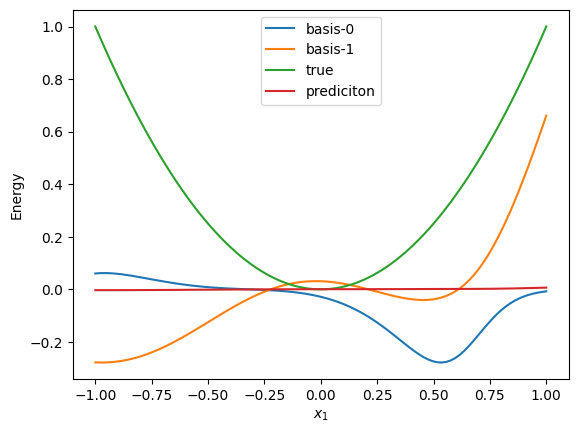

In [10]:
def show_basis(model, tt):
    x0 = np.linspace(-1, 1, 100)
    x = np.zeros((100, 3))
    x[:, 0] = x0
    basis = model.basis(jnp.array(x))
    for i in range(model.chunk_size):
        plt.plot(x0, np.array(basis[0][:, i]), label=f"basis-{i}")
    plt.plot(x0, x0**2, label="true")
    norm, W = get_norm_W(tt)
    y = model(jnp.array(x), W, norm)
    plt.plot(x0, np.array(y.squeeze(1)), label="prediciton")
    plt.legend()
    plt.xlabel("$x_1$")
    plt.ylabel("Energy")
    plt.show()


show_basis(model, tt)

### Train basis iteratively

In [11]:
losses = []
norm, W = get_norm_W(tt)
for _ in tqdm(range(1000)):
    loss = train_step(model, optimizer, x_samples, y_samples, W, norm)
    losses.append(loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Show training trace

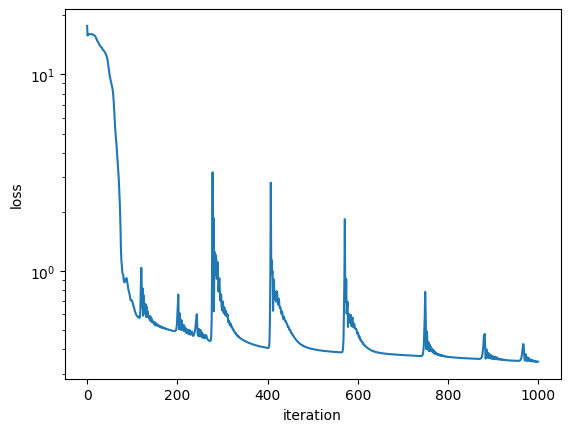

In [12]:
def show_trace(losses):
    plt.plot(losses)
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.yscale("log")
    plt.show()


show_trace(losses)

### Train tensor train with fixed basis

See also [pompon.optimizer.sweeper.sweep](../reference/optimizer.sweeper.sweep.qmd).

In [13]:
sweep?

Signature:
sweep(
    *,
    tt: pompon.layers.tt.TensorTrain,
    basis: list[jax.Array],
    y: jax.Array,
    nsweeps: int = 2,
    maxdim: int | list[int] | numpy.ndarray = 30,
    cutoff: float | list[float] | numpy.ndarray = 0.01,
    optax_solver: optax._src.base.GradientTransformation | None = None,
    opt_maxiter: int = 1000,
    opt_tol: float | list[float] | numpy.ndarray | None = None,
    opt_lambda: float = 0.0,
    onedot: bool = False,
    use_CG: bool = False,
    use_scipy: bool = False,
    use_jax_scipy: bool = False,
    method: str = 'L-BFGS-B',
    ord: str = 'fro',
    auto_onedot: bool = True,
)
Docstring:
Tensor-train sweep optimization

Args:
    tt (TensorTrain): the tensor-train model.
    basis (list[Array]): the basis functions.
    y (Array): the target values.
    nsweeps (int): The number of sweeps.
    maxdim (int, list[int]): the maximum rank of TT-sweep.
    cutoff (float, list[float]): the ratio of truncated singular values for TT-sweep.
        W

In [14]:
norm, W = get_norm_W(tt)
basis = model.basis(x_samples)
basis[0].shape

(256, 2)

In [15]:
y_samples.shape

(256, 1)

In [16]:
sweep(
    tt=tt,
    basis=basis,
    y=y_samples,
    nsweeps=2,
    maxdim=2,
    opt_maxiter=100,
    optax_solver=optax.adam(1.0e-03),
    # use_CG=True,
    onedot=False,
    auto_onedot=False,
)

  0%|          | 0/2 [00:00<?, ?it/s]

### Repeat tensor train optimization & basis optimization

In [17]:
tx = optax.adam(1e-5)
optimizer = nnx.Optimizer(model, tx)

for i in tqdm(range(10000)):
    if i % 500 == 0:
        norm, W = get_norm_W(tt)
        basis = model.basis(x_samples)
        sweep(
            tt=tt,
            basis=basis,
            y=y_samples,
            nsweeps=1,
            maxdim=2,
            opt_maxiter=200,
            # optax_solver=optax.adam(1.e-04),
            use_CG=True,
            onedot=False,
            auto_onedot=False,
        )
        norm, W = get_norm_W(tt)
    loss = train_step(model, optimizer, x_samples, y_samples, W, norm)
    losses.append(loss)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

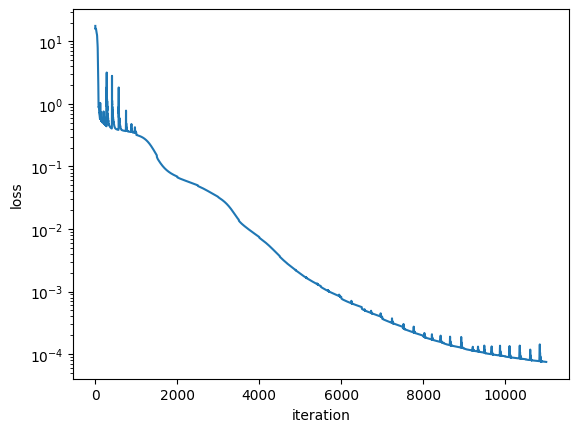

In [18]:
show_trace(losses)

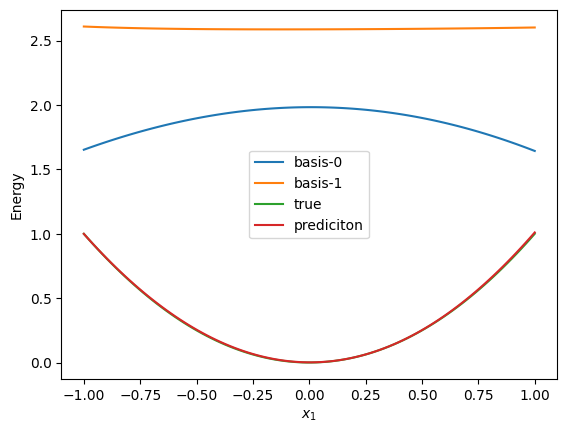

In [19]:
show_basis(model, tt)

## Train with forces

### Train basis with fixed tensor-train

Define function that returns $-\frac{\partial V}{\partial x}$ by auto differentiation

In [20]:
from functools import partial


def get_force(x, model, norm, W):
    def func(x, model, norm, W):
        if x.ndim == 1:
            # When no-batch
            x = x[jnp.newaxis, :]
            return -1.0 * model(x, norm=norm, W=W).squeeze(0)
        else:
            return -1.0 * model(x, norm=norm, W=W)

    ener_fn = partial(func, model=model, norm=norm, W=W)
    jacobian = jax.vmap(jax.jacrev(ener_fn))(x)  # (batch, out, in)
    return jacobian.squeeze(-2)  # (batch, in)

Define train_step which has a loss function
$$
\mathcal{L} = \frac{1}{2|\mathcal{D}|} \sum_{\boldsymbol{x}, E, \boldsymbol{F} \in \mathcal{D}} \left[\left(\hat{V}(\boldsymbol{x})-V\right)^2 + \left(\hat{\mathbf{F}}(\boldsymbol{x})-\mathbf{F}\right)^2\right]
$$

In [21]:
@nnx.jit
def train_step(model, optimizer, x, y, f, W, norm):
    def _loss_fn(model):
        pred = model(x, W, norm)
        loss = jnp.mean((pred - y) ** 2)
        pred_force = get_force(x, model, norm, W)
        loss += (
            jnp.sum((pred_force.flatten() - f.flatten()) ** 2)
            / pred_force.shape[0]
        )
        return loss

    loss, grads = nnx.value_and_grad(_loss_fn)(model)
    optimizer.update(grads)
    return loss

Check `train_step` works

In [22]:
norm, W = get_norm_W(tt)
loss = train_step(model, optimizer, x_samples, y_samples, f_samples, W, norm)
loss

Array(0.38388169, dtype=float64)

### Train basis iteratively

In [23]:
for _ in tqdm(range(1000)):
    # lax while loop may be fast
    loss = train_step(
        model, optimizer, x_samples, y_samples, f_samples, W, norm
    )
    losses.append(loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

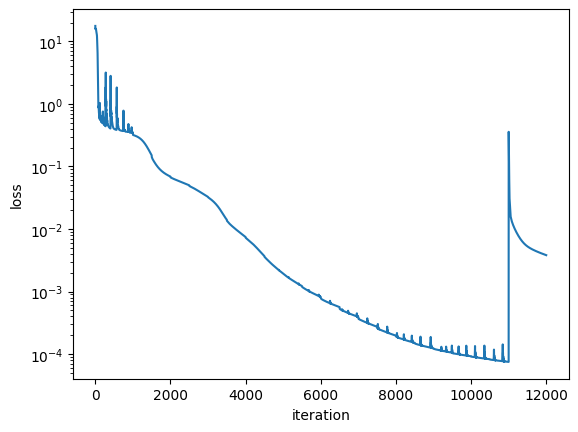

In [24]:
show_trace(losses)

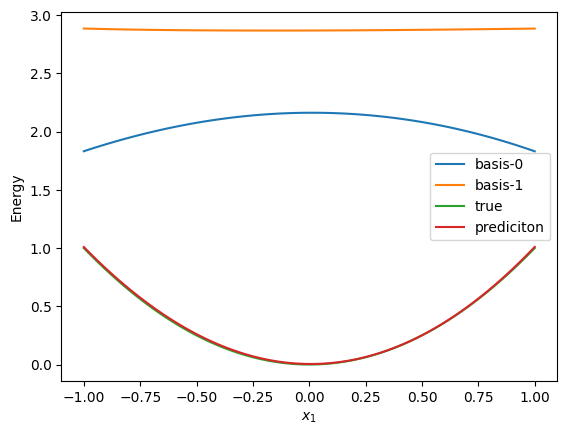

In [25]:
show_basis(model, tt)

### Train tensor train with fixed basis

Prepare basis gradient $-\frac{\partial \Phi}{\partial x_i}$

In [26]:
def get_partial_basis(x, i, model):
    assert x.ndim == 2  # batch, dim
    x = x[:, i : i + 1]

    def func(x, model):
        if x.ndim == 1:
            x = x[jnp.newaxis, :]
            return -1.0 * model.basis(x, i)[0].squeeze(0)
        else:
            return -1.0 * model.basis(x, i)[0]

    basis_fn = partial(func, model=model)
    # since in=1 < out=number of basis, we should use forward differentiation
    jacobian = jax.vmap(jax.jacfwd(basis_fn))(x)  # batch, out, in
    return jacobian.squeeze(2)  # batch, out


partial_basis_i = get_partial_basis(x_samples, 0, model)

`partial_basis=`
$
\left[
-\frac{\partial \phi_{\rho_1}}{\partial x_1}, -\frac{\partial \phi_{\rho_2}}{\partial x_2}, \cdots, -\frac{\partial \phi_{\rho_n}}{\partial x_n}
\right]
$

In [27]:
partial_basis = [
    get_partial_basis(x_samples, i, model) for i in range(x_samples.shape[1])
]

`basis=`
$\left[\phi_{\rho_1}, \phi_{\rho_2}, \cdots, \phi_{\rho_n} \right]$

In [28]:
basis = model.basis(x_samples)

`concat_y=`$y_p$
where $p=k \otimes i$
$$
y_p = y_i^{(k)} = 
\begin{cases}
\boldsymbol{F}_i^{(k)} & \mathrm{for} \quad i \leq n \\
E^{(k)} & \mathrm{for} \quad i = n+1
\end{cases}
$$

In [29]:
concat_y = jnp.vstack(
    [f_samples[:, i : i + 1] for i in range(len(basis))] + [y_samples]
)
print(concat_y.shape)

(1024, 1)


`basis_list=`
$$
\begin{bmatrix}
[\partial_{x_1}\phi_{\rho_1} & \phi_{\rho_2} & \cdots & \phi_{\rho_n} ], \\
[\phi_{\rho_1} & \partial_{x_2}\phi_{\rho_2} & \cdots & \phi_{\rho_n} ], \\
& & \vdots & & \\
[\phi_{\rho_1} & \phi_{\rho_2} & \cdots & \partial_{x_n}\phi_{\rho_n} ], \\
[\phi_{\rho_1} & \phi_{\rho_2} & \cdots & \phi_{\rho_n} ]
\end{bmatrix}
$$


`concat_basis=`
$
\left[\varphi_{\rho_1}, \varphi_{\rho_2}, \cdots, \varphi_{\rho_n}\right]
$
where
$$
\varphi_{\rho_j}^p = \varphi_{i, \rho_i}^{(k)} = 
\begin{cases}
-\partial_{x_j}\phi_{\rho_j} & \mathrm{for} \quad i=j \\
\phi_{\rho_j} & \mathrm{otherwise}
\end{cases}
$$

In [30]:
def get_concat_basis(x: jax.Array, model: CustomModel) -> list[jax.Array]:
    """
    Args:
        x (jax.Array): postions
        model (CustomModel): model

    Returns:
        list[jax.Array]: derivative concatenated basis
    """
    partial_basis = [get_partial_basis(x, i, model) for i in range(x.shape[1])]
    basis = model.basis(x)
    basis_list = []
    for i in range(len(basis)):
        basis_row = [
            ϕ.copy() if k != i else dϕ.copy()
            for k, (ϕ, dϕ) in enumerate(zip(basis, partial_basis, strict=True))
        ]
        basis_list.append(basis_row)
    basis_list.append(basis)
    concat_basis = [
        jnp.vstack([φ[i] for φ in basis_list]) for i in range(len(basis))
    ]
    return concat_basis


concat_basis = get_concat_basis(x_samples, model)
print(concat_basis[0].shape)

(1024, 2)


### Train tensor train with fixed basis

Only `basis` & `y` are changed from energy optimization.

In [31]:
sweep(
    tt=tt,
    basis=concat_basis,  # <- changed!!
    y=concat_y,  # <- changed!!
    nsweeps=10,
    maxdim=2,
    opt_maxiter=200,
    # optax_solver=optax.adam(1.e-04),
    use_CG=True,
    onedot=True,
    auto_onedot=False,
)

  0%|          | 0/10 [00:00<?, ?it/s]

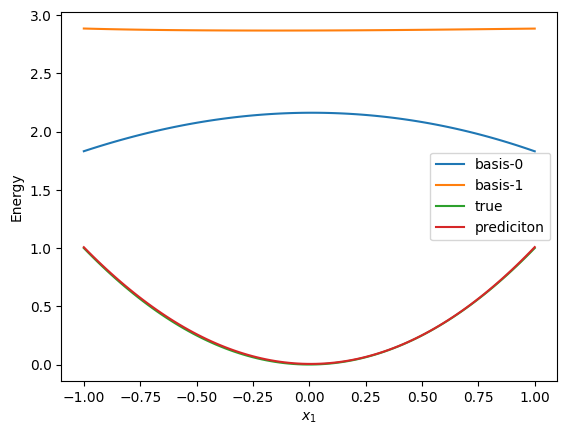

In [32]:
show_basis(model, tt)

### Repeat tensor train optimization & basis optimization

In [33]:
tx = optax.adam(1e-5)
optimizer = nnx.Optimizer(model, tx)
for i in tqdm(range(10000)):
    if i % 500 == 0:
        norm, W = get_norm_W(tt)
        concat_basis = get_concat_basis(x_samples, model)
        sweep(
            tt=tt,
            basis=concat_basis,
            y=concat_y,
            nsweeps=1,
            maxdim=2,
            opt_maxiter=200,
            # optax_solver=optax.adam(1.e-04),
            use_CG=True,
            onedot=True,
            auto_onedot=False,
        )
        norm, W = get_norm_W(tt)
    loss = train_step(
        model, optimizer, x_samples, y_samples, f_samples, W, norm
    )
    losses.append(loss)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

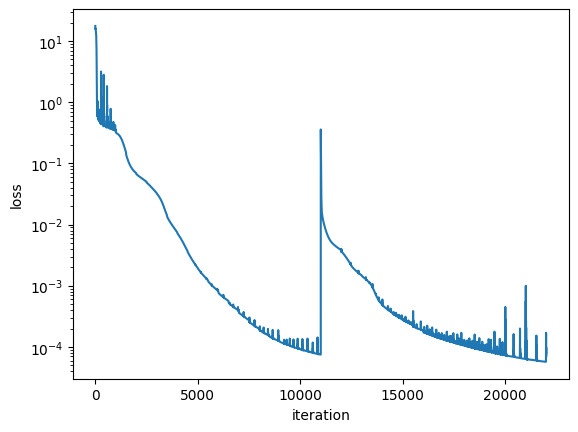

In [34]:
show_trace(losses)

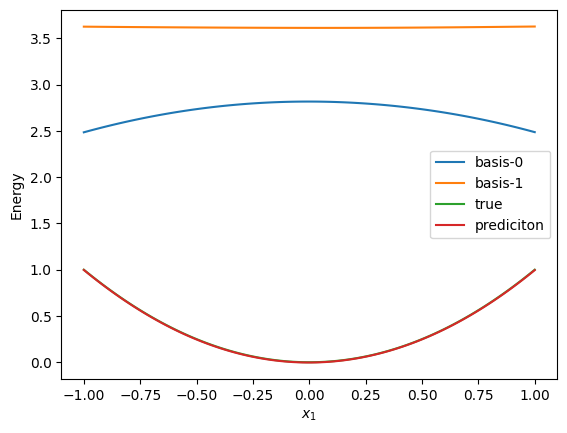

In [35]:
show_basis(model, tt)

## Access optimized tensor train cores

In [36]:
for i, core in enumerate(tt):
    print(i, core)
    print(core.data)

0 Core(shape=(1, 2, 2), leg_names=('β0', 'i1', 'β1'), dtype=float64)
[[[-0.23738906 -0.24130501]
  [-0.93898443  0.06104555]]]
1 Core(shape=(2, 2, 2), leg_names=('β1', 'i2', 'β2'), dtype=float64)
[[[-0.58550331  0.05419654]
  [ 0.80821735  0.03214547]]

 [[-0.8099358  -0.07141367]
  [-0.57994308 -0.05069637]]]
2 Core(shape=(2, 2, 1), leg_names=('β2', 'i3', 'β3'), dtype=float64)
[[[-0.99307731]
  [ 0.11746261]]

 [[ 0.11746261]
  [ 0.99307731]]]
